In [1]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from typing import List
from sklearn.preprocessing import StandardScaler

In [2]:
from src.utils import Utilities

In [3]:
dr = Utilities.DatasetReader(is_colab = False)
data = dr.readFile()
df = dr.createDataFrame()

Opening file: dataset/dataset.csv
Reading file line by line...
Number of maximum possible columns: 65
Our cols are: ['event_ID', 'process_ID', 'event_weight', 'MET', 'MET_Phi']
Creating deep copy of cols
Number of cols: 65

Slicing list of cols: ['obj_10', 'E_10', 'pt_10', 'eta_10', 'phi_10', 'obj_11', 'E_11', 'pt_11', 'eta_11', 'phi_11']


In [4]:
df_normalized = df.copy()
df_normalized[df_normalized.columns] = StandardScaler().fit_transform(df_normalized)

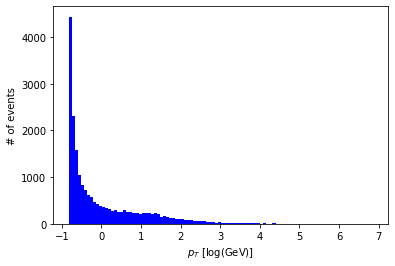

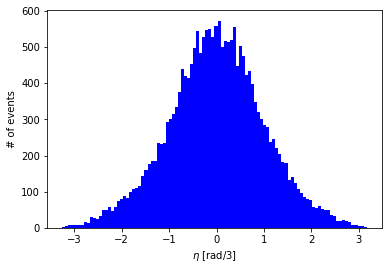

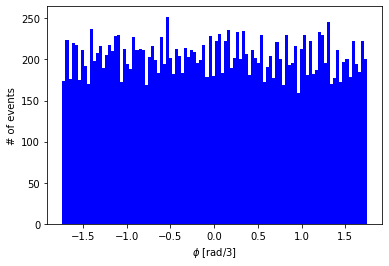

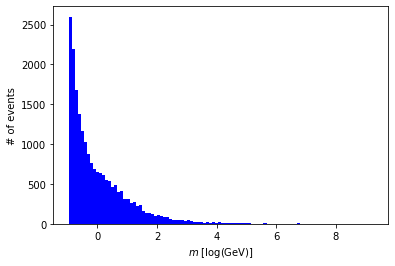

In [5]:
Utilities.plot_hist(df_normalized, False)

In [7]:
# shuffling the data before splitting
df_normalized = shuffle(df_normalized)

# split the data into train and test with a ratio of 20%
train_x, test_x = train_test_split(df_normalized, test_size=0.2, random_state=1)

train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

print('Train data shape: ')
print(train_x.shape)
print('Test data shape: ')
print(test_x.shape)

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

Train data shape: 
(16292, 4)
Test data shape: 
(4073, 4)


In [8]:

bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

In [9]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4, leakyRelu: bool = False):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 100)
        self.en2 = nn.Linear(100, 50)
        self.en3 = nn.Linear(50, 10)
        self.en4 = nn.Linear(10, 3)
        self.de1 = nn.Linear(3, 10)
        self.de2 = nn.Linear(10, 50)
        self.de3 = nn.Linear(50, 100)
        self.de4 = nn.Linear(100, n_features)
        self.relu = leakyRelu
        if self.relu:
            self.leakyRelu = nn.LeakyReLU()
        else:
            self.tanh = nn.Tanh()
        
    def encode(self, x):
        if self.relu:
            return self.en4(self.leakyRelu(self.en3(self.leakyRelu(self.en2(self.leakyRelu(self.en1(x)))))))
        else:
            return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        if self.relu:
            return self.de4(self.leakyRelu(self.de3(self.leakyRelu(self.de2(self.leakyRelu(self.de1(self.leakyRelu(x))))))))
        else:
            return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
    
    def describe(self):
        return '4-200-200-20-3-20-200-200-4'

In [10]:
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=100, bias=True)
  (en2): Linear(in_features=100, out_features=50, bias=True)
  (en3): Linear(in_features=50, out_features=10, bias=True)
  (en4): Linear(in_features=10, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=10, bias=True)
  (de2): Linear(in_features=10, out_features=50, bias=True)
  (de3): Linear(in_features=50, out_features=100, bias=True)
  (de4): Linear(in_features=100, out_features=4, bias=True)
  (tanh): Tanh()
)

In [12]:
from fastai.metrics import mse, partial
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.test_utils import *

loss_function = nn.MSELoss()

weight_decay = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=weight_decay, loss_func=loss_function, cbs=recorder)

Learning rate with the minimum loss: 0.006918309628963471
Learning rate with the steepest gradient: 0.010964781977236271


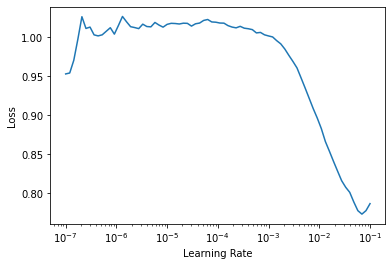

In [13]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [14]:

import time

start = time.perf_counter() # Starts timer
# train our autoencoder for 100 epochs
learn.fit_one_cycle(100, lr_steep)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

epoch,train_loss,valid_loss,time
0,0.633061,0.391250,00:00
0,0.633061,0.391250,00:00
1,0.301991,0.158361,00:00
1,0.301991,0.158361,00:00
2,0.172407,0.111039,00:01
2,0.172407,0.111039,00:01
3,0.110912,0.079129,00:00
3,0.110912,0.079129,00:00
4,0.082919,0.070707,00:00
4,0.082919,0.070707,00:00


Training took 98.51681020000001 seconds
